In [2]:
# ============================================
# 1. Load Dataset  &  Train/Test Split
# ============================================
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("creditcard.csv")
print("Dataset shape:", df.shape)
print("Class distribution (original):")
print(df["Class"].value_counts())

# 常见做法：去掉 Time 列（如果课程要求保留，也可不删）
X = df.drop(columns=["Class", "Time"])
y = df["Class"]

# 先切分，再只在训练集上做上采样
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_df = pd.concat([X_train, y_train], axis=1)
maj = train_df[train_df.Class == 0]
minr = train_df[train_df.Class == 1]

minr_up = resample(minr, replace=True, n_samples=len(maj), random_state=42)
train_up = pd.concat([maj, minr_up]).sample(frac=1, random_state=42).reset_index(drop=True)

X_train_up = train_up.drop(columns=["Class"])
y_train_up = train_up["Class"]

print("\nTrain distribution AFTER upsampling:")
print(y_train_up.value_counts())
print("\nTest distribution (real, untouched):")
print(y_test.value_counts())


Dataset shape: (284807, 31)
Class distribution (original):
Class
0    284315
1       492
Name: count, dtype: int64

Train distribution AFTER upsampling:
Class
0    227451
1    227451
Name: count, dtype: int64

Test distribution (real, untouched):
Class
0    56864
1       98
Name: count, dtype: int64


In [3]:
# ============================================
# 2. Baseline model (no privacy)  &  DP model (Laplace on Amount)
# ============================================
from sklearn.preprocessing import StandardScaler

# ---- Baseline（无隐私）----
clf_original = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
clf_original.fit(X_train_up, y_train_up)
y_pred_original = clf_original.predict(X_test)
cm_original = confusion_matrix(y_test, y_pred_original)
print("\n=== Baseline on real test ===")
print(classification_report(y_test, y_pred_original, digits=4))

# ---- Differential Privacy（仅对训练集的 Amount 加噪）----
epsilon = 0.5                 # 隐私预算（越小噪声越大）
sensitive_col = "Amount"

# 1) 用训练集确定裁剪范围，避免极端值放大噪声影响
clip_min = np.percentile(X_train_up[sensitive_col], 1)
clip_max = np.percentile(X_train_up[sensitive_col], 99)
amt_train = np.clip(X_train_up[sensitive_col].to_numpy(), clip_min, clip_max).reshape(-1,1)

# 2) 标准化（仅在训练集拟合）
scaler = StandardScaler().fit(amt_train)
amt_train_std = scaler.transform(amt_train).ravel()

# 3) 加 Laplace 噪声（scale = 1/epsilon）
noise = np.random.laplace(loc=0.0, scale=1/epsilon, size=amt_train_std.shape[0])
amt_train_noisy_std = amt_train_std + noise

# 4) 反标准化回原尺度（也可直接用标准化后的值）
amt_train_noisy = scaler.inverse_transform(amt_train_noisy_std.reshape(-1,1)).ravel()

X_train_priv = X_train_up.copy()
X_train_priv[sensitive_col] = amt_train_noisy

clf_privacy = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
clf_privacy.fit(X_train_priv, y_train_up)
y_pred_privacy = clf_privacy.predict(X_test)
cm_privacy = confusion_matrix(y_test, y_pred_privacy)

print("\n=== DP (Laplace on Amount, train-only) on real test ===")
print(classification_report(y_test, y_pred_privacy, digits=4))



=== Baseline on real test ===
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9506    0.7857    0.8603        98

    accuracy                         0.9996     56962
   macro avg     0.9751    0.8928    0.9301     56962
weighted avg     0.9995    0.9996    0.9995     56962


=== DP (Laplace on Amount, train-only) on real test ===
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9506    0.7857    0.8603        98

    accuracy                         0.9996     56962
   macro avg     0.9751    0.8928    0.9301     56962
weighted avg     0.9995    0.9996    0.9995     56962



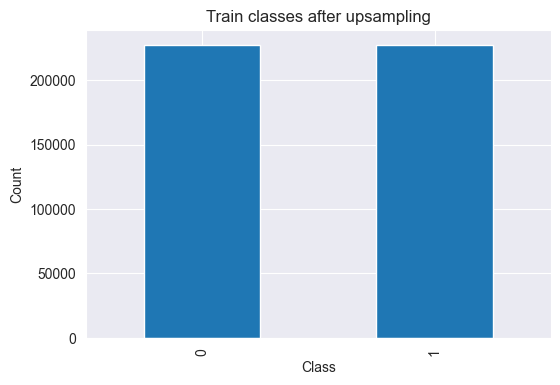

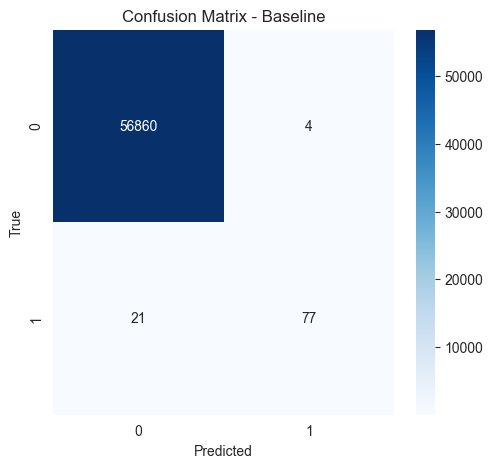

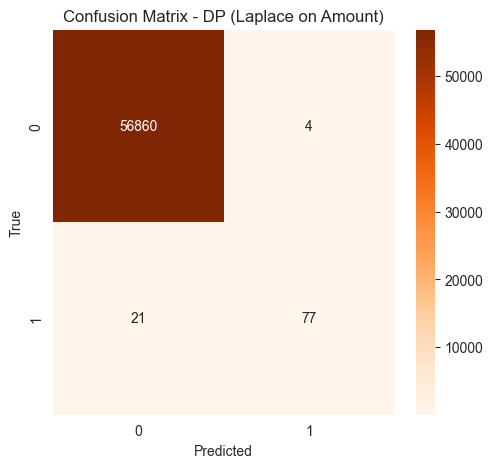


Accuracy (Baseline): 0.999561
Accuracy (DP)     : 0.999561
Note: Smaller ε → stronger privacy, typically lower accuracy.


In [4]:
# ============================================
# 3. Plots & Accuracy comparison
# ============================================
plt.figure(figsize=(6,4))
y_train_up.value_counts().plot(kind='bar', title='Train classes after upsampling')
plt.xlabel('Class'); plt.ylabel('Count'); plt.show()

plt.figure(figsize=(5.5,5))
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

plt.figure(figsize=(5.5,5))
sns.heatmap(cm_privacy, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - DP (Laplace on Amount)'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

acc_original = accuracy_score(y_test, y_pred_original)
acc_privacy  = accuracy_score(y_test, y_pred_privacy)
print(f"\nAccuracy (Baseline): {acc_original:.6f}")
print(f"Accuracy (DP)     : {acc_privacy:.6f}")
print("Note: Smaller ε → stronger privacy, typically lower accuracy.")
